In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_train = pd.read_csv('train_final.csv')
df_test = pd.read_csv('test_final.csv')

In [2]:
df_test.head()

,Id,2,3,4,5,6,7,8,9,10,...,375,376,377,378,379,380,381,382,383,384
0,2604,0,1,0,0,0,0,0,0,1,...,0,0,0,1,2175.0,0,1,1,0.195686,-0.694456
1,2605,0,1,0,0,0,1,0,0,1,...,0,1,0,1,5667.0,0,1,6,-0.789394,1.159170
2,2606,0,0,70,0,0,0,0,0,1,...,0,0,0,1,3498.0,0,1,3,-2.717848,-1.179772
3,2607,0,0,0,0,0,1,0,0,1,...,0,0,0,4,4465.0,0,1,4,1.953888,0.756751
4,2608,0,0,0,0,0,0,0,0,1,...,0,0,0,13,-3968.0,0,1,1,5.102421,-2.573633


In [3]:
target = df_train["Y"]
id = df_test["Id"].values

In [4]:
df_train.drop(['Id','Y'],axis=1,inplace=True)

In [5]:
df_test.drop(['Id'],axis=1,inplace=True)

In [6]:
print('Binary features summary statistics')
df_train.describe().T.style.bar(subset = ['mean'], color = 'grey').bar(subset = ['std'],color = 'grey').background_gradient(cmap = 'GnBu')

Binary features summary statistics


,count,mean,std,min,25%,50%,75%,max
2,2603.000000,0.000768,0.027714,0.000000,0.000000,0.000000,0.000000,1.000000
3,2603.000000,0.463312,0.498748,0.000000,0.000000,0.000000,1.000000,1.000000
4,2603.000000,-46.734537,394.284920,-3136.000000,0.000000,0.000000,0.000000,1175.000000
5,2603.000000,0.000768,0.027714,0.000000,0.000000,0.000000,0.000000,1.000000
6,2603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2603.000000,0.275836,0.447020,0.000000,0.000000,0.000000,1.000000,1.000000
8,2603.000000,0.023434,0.151308,0.000000,0.000000,0.000000,0.000000,1.000000
9,2603.000000,0.000384,0.019600,0.000000,0.000000,0.000000,0.000000,1.000000
10,2603.000000,0.955436,0.206384,0.000000,1.000000,1.000000,1.000000,1.000000
11,2603.000000,0.001921,0.043794,0.000000,0.000000,0.000000,0.000000,1.000000


In [7]:
from sklearn import preprocessing

columns = ['4','63','132', '146', '180','382', '119', '198', '379']
minmax_scale_train = preprocessing.MinMaxScaler().fit(df_train[columns])
df_train[columns] = minmax_scale_train.transform(df_train[columns])

minmax_scale_test = preprocessing.MinMaxScaler().fit(df_test[columns])
df_test[columns] = minmax_scale_test.transform(df_test[columns])

In [8]:
# Trail one, dropping all columns that seem weird.

#before and after 
#drop_zeros = ['6','30','35', '40', '60','80', '90', '101','102', '113', '118', '129', '138', '142','163', '206', '216', '233', '239', '247','250', '253', '259', '305', '307', '315', '322', '323', '333', '350', '364', '120', '208']
#drop_extras = ['119']

#t1_train = df_train.drop(drop_zeros,axis=1)
#t1_test = df_test.drop(drop_zeros,axis=1)
# t1_train =  df_train.drop(drop_extras,axis=1)        
# t1_test = df_test.drop(drop_extras,axis=1)
t1_train = df_train
t1_test = df_test

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

x_train, x_test, y_train, y_test = train_test_split(t1_train, target, test_size=0.33, random_state=1)

In [10]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(solver='liblinear').fit(x_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


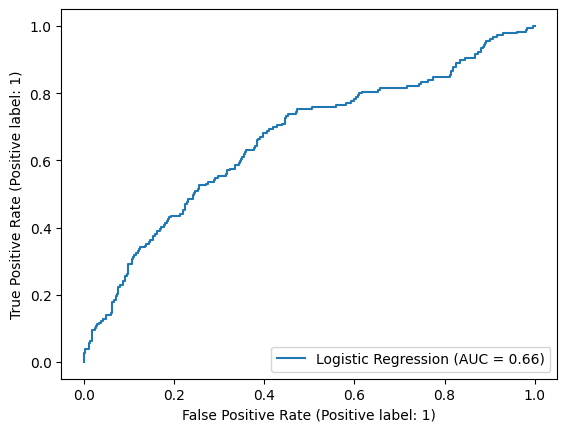

In [11]:
plot_roc_curve(log_reg, x_test, y_test, name = 'Logistic Regression')

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = log_reg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for LogisticRegression: ", rmse)

RMSE for LogisticRegression:  0.4727744874131615


In [13]:
score = cross_val_score(log_reg, x_train, y_train)
print ("Cross validation score for LogisticRegression: ",np.mean(score)*100)

Cross validation score for LogisticRegression:  75.17307248954319


In [14]:
y_proba = log_reg.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

0.6622329937561617

In [15]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=500, 
                 learning_rate=0.03, depth=6, verbose=0)

catboost.fit(x_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


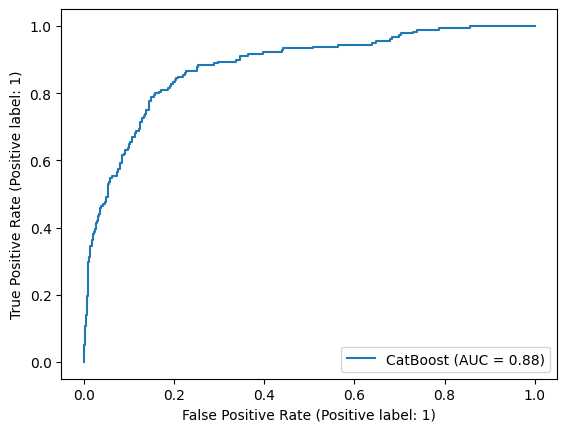

In [16]:
plot_roc_curve(catboost, x_test, y_test, name = 'CatBoost')

In [17]:
y_pred = catboost.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for catboost: ", rmse)

RMSE for catboost:  0.3753151566642172


In [18]:
score = cross_val_score(catboost, x_train, y_train)
print ("Cross validation score for catboost: ",np.mean(score)*100)

Cross validation score for catboost:  83.77498929618285


In [19]:
y_proba = catboost.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

0.8800115018074268

In [20]:
sub_proba = catboost.predict_proba(t1_test)
pred_col=np.c_[id,sub_proba[:,1]]

submission = pd.DataFrame(pred_col, columns = ['Id','Y'])
submission["Id"] = submission["Id"].astype("Int32")
submission

,Id,Y
0,2604,0.064080
1,2605,0.066452
2,2606,0.035888
3,2607,0.019740
4,2608,0.625243
...,...,...
3599,6203,0.211618
3600,6204,0.028582
3601,6205,0.006698
3602,6206,0.033433


In [21]:
submission.to_csv('submission.csv', index=False)

In [22]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=150)
rf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=150)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


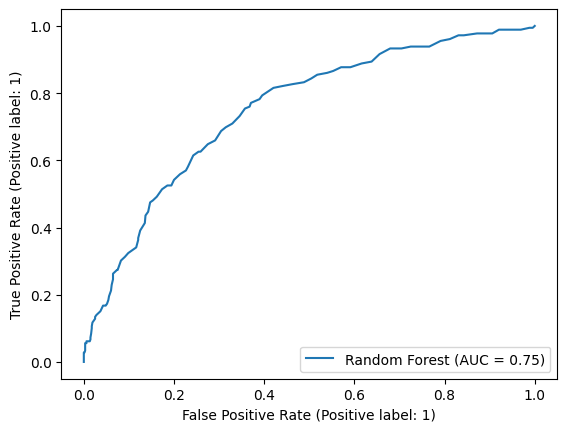

In [23]:
plot_roc_curve(rf, x_test, y_test, name = 'Random Forest')

In [24]:
y_pred = rf.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for RandomForest: ", rmse)

RMSE for RandomForest:  0.4602980256418431


In [25]:
score = cross_val_score(rf, x_train, y_train)
print ("Cross validation score for RandomForest: ",np.mean(score)*100)

Cross validation score for RandomForest:  77.52478345354544


In [26]:
y_proba = rf.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

0.7489648373315807

In [27]:
from sklearn.svm import SVC

# Initialize SVM classifier
clf = SVC(kernel="rbf", C=0.025, probability=True)

clf = clf.fit(x_train,y_train)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


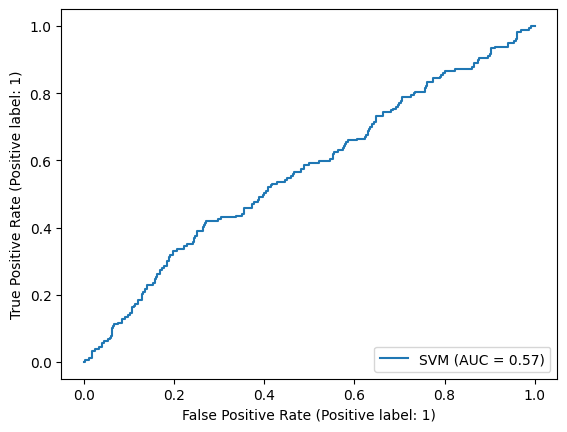

In [28]:
plot_roc_curve(clf, x_test, y_test, name = 'SVM')

y_pred = clf.predict(x_test)

In [29]:

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for SVM: ", rmse)

y_proba = clf.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

RMSE for SVM:  0.45648859717202045


0.5664147223135063

RMSE for RandomForest:  0.47767383575445826


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.5500369700953006

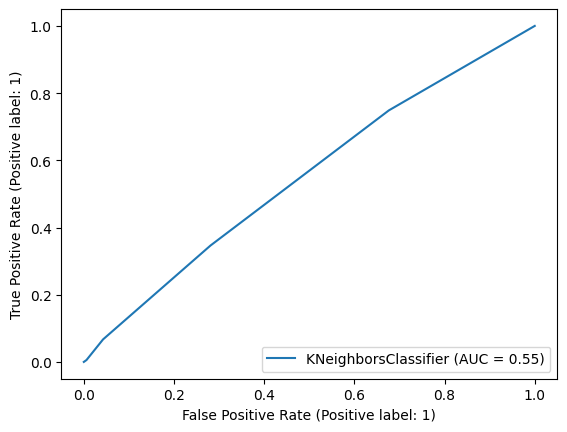

In [30]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train,y_train)

plot_roc_curve(neigh, x_test, y_test, name = 'KNeighborsClassifier')

y_pred = neigh.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for RandomForest: ", rmse)

y_proba = neigh.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


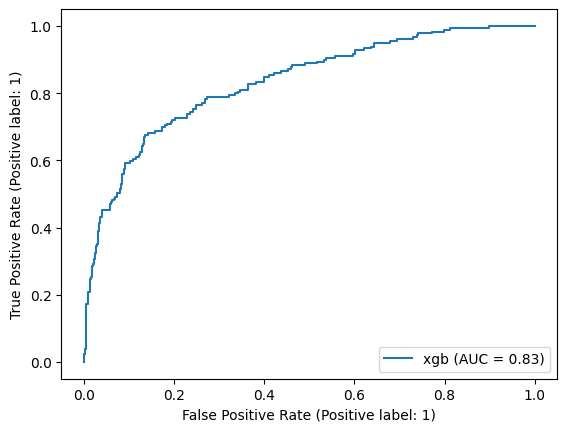

In [31]:
import xgboost as xgb

xgb = xgb.XGBClassifier(n_estimators=100)

xgb.fit(x_train, y_train)

plot_roc_curve(xgb, x_test, y_test, name = 'xgb')

In [33]:
from mlxtend.regressor import StackingCVRegressor


stack = StackingCVRegressor(regressors=(log_reg, rf, xgb, catboost),
                            meta_regressor=xgb, cv=12,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42)

In [35]:
stack.fit(x_train, y_train)
#plot_roc_curve(stack, x_test, y_test, name = 'stack')

StackingCVRegressor(cv=12,
                    meta_regressor=XGBClassifier(base_score=0.5,
                                                 booster='gbtree',
                                                 callbacks=None,
                                                 colsample_bylevel=1,
                                                 colsample_bynode=1,
                                                 colsample_bytree=1,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None, gamma=0,
                                                 gpu_id=-1,
                                                 grow_policy='depthwise',
                                                 importance_type=None,
                                                 interaction_constraints='',
                                                 learning_rate=0.300000012,
                                                 max_b...
                                              max_bin=256, max_cat_to_onehot=4,
                                              max_delta_step=0, max_depth=6,
                                              max_leaves=0, min_child_weight=1,
                                              missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=0,
                                              num_parallel_tree=1,
                                              predictor='auto', random_state=0,
                                              reg_alpha=0, reg_lambda=1, ...),
                                <catboost.core.CatBoostClassifier object at 0x1611adf60>),
                    shuffle=False, store_train_meta_features=True,
                    use_features_in_secondary=True)

In [37]:
y_proba = stack.predict(x_test)
#roc_auc_score(y_test, y_proba[:,1])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
0.8832073611567532
0.8834949063424252
0.8843328951692409
0.8843739730529084
0.8842260926717056